# Package introductory notebook : implementing your own PDE problem

## Reminder on the mathematical context

A detailed introduction on learning PDE with PINNS is available in the [Background section](https://mia_jinns.gitlab.io/jinns/math_pinn.html) of the documentation. We simply recall the general statement : we wish to learn a solution $u$ to a PDE driven by the a differential operator $\mathcal{N}_\nu$ on a space domain $\Omega \subset \mathbb{R}^d$, a time interval $I = [0, T]$, with possible border condition on $\partial \Omega$ and initial condition $u(0, x) = u_0(x)$.

$$
\begin{equation}
\begin{cases}
\tag{PDE}
& \mathcal{N}_\nu[u](t, x) = 0, \quad \forall  t, x \in I\times \Omega, & \textrm{(Dynamic)}\\
& u(0, \cdot) = u_0(x), \quad \forall x \in \omega & \textrm{(Initial condition)} \\
& \mathcal{B}[u](dx) = f(dx), \quad \forall dx \in \partial \Omega & \textrm{(Boundary condition)}
\end{cases}
\end{equation}
$$

We wish to learn an estimator of the true solution $\hat{u}$ in the form of a parametric neural network with weights and biases $\theta$. The jinns package solves optimization of the following form:
$$
\hat{u} = u_\hat{\theta}\quad \textrm{with:} \quad \hat{\theta} \in \arg \min_{\theta} \left\{ L(\theta) = \Vert  \mathcal{N}_\nu[u_\theta] \Vert^2_{dyn} + w_{init} \Vert u_{\theta}(\cdot, 0) - u_0 \Vert^2_{init} + w_b \Vert \mathcal{B}[u_{\theta}] - f \Vert^2_{border} \right\},
$$
via stochastic gradient on mini-batches of $\Omega$, $\partial \Omega$ and $I$.

## Solving forward PDE problems with jinns

This tutorial focuses on solving forward problem with **jinns**. In order to define her PDE problem, a user need to define

 1. The neural network $u_\theta$ : **jinss** may work with any JAX-compatible package, although we recommand using the [equinox](https://pypi.org/project/equinox/) package.
 2. A `DataGenerator` object that handles the generation of the mesh on $I$, $\Omega$, $\partial \Omega$.
 3. A so-called `DynamicLoss`, which is an object defining the differential operator $\mathcal{N}_\nu[u_\theta]$, *i.e.* the PDE *dynamic* part of the global loss.
 4. The global loss $L(\theta)$ with boundary condition and initial condition.
 5. An optimization solver

We will go through all these steps with the toy example of the 1-D Burger equation defined on $I \times \Omega = [0, T] \times [-1, 1]$ as:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \nu \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), & \textrm{ (Initial condition)}\\
u(t,-1)=u(t,1)=0, & \textrm{ (Boundary condition)}
\end{cases}
$$
where $\nu = 0.01 \pi$ is a single scalar equation parameters in this example.

Although we emphasize that in-depth Notebooks are available for several 2-D stationary and non-stationary PDEs:

 * Fokker-Planck equation (Ornshtein-Ulhenbeck)
 * FisherKPP
 * Burger Equation
 * Navier-Stokes

In [19]:
import jinns
import jax
import jax.random as random
import jax.numpy as jnp
import equinox as eqx
import optax
from jaxopt import OptaxSolver
import matplotlib.pyplot as plt
from functools import partial

In [2]:
nu = 1 / (100 * jnp.pi)

### Setting the random key in JAX

If you are new to JAX, we recommand reading the documentation on [pseudo-random number generation](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html#pseudo-random-numbers-in-jax) and the differences with NumPy.

In [3]:
key = random.PRNGKey(42)

### Defining your neural network 

The **jinns** package requires a function $u(t, x, \theta, \nu)$ where $\theta$ are the neural network parameters, while $\nu$ are the equation parameters. Of course, the user is free to make the network depend on $\nu$ or not.

The following block-cells defines the function $u_\theta = f_{m, \theta} \circ \ldots \circ f_{1, \theta}$ where $m$ is the number of layers, and $f_{i, \theta}(x) = \sigma(A_ix + b_i)$ are simple linear functions followed by a non-linearity $\sigma$. We will work with the [equinox](https://pypi.org/project/equinox/) package which has PyTorch-like API but creates JAX-compatible function, which is required.

In our example, we chose arbitrarily $m=4$, with 20 neurons for each layer and $\sigma = \textrm{tanh}$. The dimension of the input $(t, x)$ is $d+1 = 2$.


In [4]:

class MLP(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = random.split(key, 4)

        self.layers = [
            eqx.nn.Linear(2, 20, key=key1),
            jax.nn.tanh,
            eqx.nn.Linear(20, 20, key=key2),
            jax.nn.tanh,
            eqx.nn.Linear(20, 20, key=key3),
            jax.nn.tanh,
            eqx.nn.Linear(20, 1, key=key4),
        ]
    def __call__(self, t):
        for layer in self.layers:
            t = layer(t)
        return t

def make_mlp(key):
    mlp = MLP(key) 
    params, static = eqx.partition(mlp, eqx.is_inexact_array)

    def init_fn():
        return params

    def apply_fn(t, x, u_params, eq_params=None): # NOTE here the unused eq_params
        model = eqx.combine(u_params, static)
        t_x = jnp.concatenate([t, x], axis=-1)
        return model(t_x)[0]

    return init_fn, apply_fn


key, subkey = random.split(key) # don't forget to split the key
init_param_fn, u = make_mlp(key)

Fortunatly, the `jinns.utils` module implements a wrapper function to synthetize the NN creation

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(key, eqx_list, eq_type="nonstatio_PDE", dim_x=1)

Notice that we return 2 functions:

 * `init_param_fn()`: returns a set of randomly drawn nn weights $\theta$ (useful for initialisation)
 * `u(t, x, nn_params, eq_params=None)` which evaluates the neural net of weights `nn_params` at points `t` and `x`. Argument `eq_params` is unused here, but necessary for compatibility with the package.

Here is an example of how to randomly initialized your neural network

In [6]:
init_nn_params = init_param_fn()
u_init = partial(u, u_params=init_nn_params)
u_init(t= jnp.zeros(1), x = jnp.zeros(1)) # u_init(0, 0)

Array(-0.300627, dtype=float32)

### Defining the mesh on $\Omega$, $\partial \Omega$ and $I$ : the `DataGeneratorPDE` class

Here, the space domain $\Omega = [-1, 1]$ and $\partial \Omega = \{-1, 1\}$ and the time domain is $I = [0, T]$. We will define an object that will allow to sample mini-batches from these 3 domains. In dimension 1, the whole $\partial \Omega = \{-1, 1\}$ is always returned. Here $\Omega$ is sampled uniformly, but a regular grid is also possible.

The `DataGeneratorPDE` object implements a `.get_batch()` method which returns a 3-tuple containing batches of points in $\Omega$, $\partial \Omega$ and $I$.

In [7]:
n = 1000
nt = 1000
nb = 2
omega_batch_size = 32
temporal_batch_size = 20
omega_border_batch_size = 2 # not used when dim == 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform" 

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

In [8]:
print(train_data.omega.shape)
omega_batch, border_batch, time_batch = train_data.get_batch()
for batch in train_data.get_batch():
    print(batch.shape)

(1000, 1)
(32, 1)
(1, 1, 2)
(20,)


**Note:** Currently, the packages only implements a cubic mesh $\prod_{j=1}^d \left[x_{min}^j, x_{max}^j\right]$ for $\Omega$. In general cases, $\Omega$ and its border may be complicated sets. The **jinns** package allows the user to define its own `DataGenetorPDE` according to her needs. However, we emphasize that your self-implementation need to be *jit-able* by JAX, thus requiring to be familiar with advanced JAX notions such as [PyTrees](https://jax.readthedocs.io/en/latest/pytrees.html#custom-pytrees-and-initialization).

### Defininition of your PDE : the PINN loss
In order to define the loss $L(\theta)$, the package procede in two-step.

    1. A `DynamicLoss` defines the differential operator $\mathcal{N}_\nu[u_\theta] = 0$, defining the PDE dynamic.
    2. The `LossPDENonStatio` class creates $L$ by gathering the dynamic loss with other terms (boundary and initial).
    
#### The PDE dynamic : the DynamicLoss class
 The Burger equation's dynamic loss is already implemented in the `jinns.loss` although we copy the code of the class for the sake of illustration.

The important thing to notice are :

 * The code uses JAX autodiff via the `grad` method to compute partial derivatives w.r.t. $t$ and $x$. See the [JAX autodiff cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) for more advanced features.
 * The `evaluate(self, t, x, u, params)` computes $\mathcal{N}_\nu[u_\theta](t, x)$, allowing $\nu$ as input.


> **Note** : the `self.set_stop_gradient(params)` method returns the dictionnary `params` with jax.lax.stop_gradient applied to some keys depending on the `self.derivatives` attribute. This allows to control the optimization procedure, telling if the gradient are taken w.r.t. to $\theta$, $\nu$ or both. See the documentation for more details.

In [9]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)

In [23]:
from jax import grad
from jinns.loss import PDENonStatio

class BurgerEquation(PDENonStatio):
    r"""
    Return the Burger dynamic loss term (in 1 space dimension):

    .. math::
        \frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
        u(t,x) - \nu \frac{\partial^2}{\partial x^2} u(t,x) = 0

    """

    def __init__(self, Tmax=1, derivatives="nn_params"):
        """
        Parameters
        ----------
        Tmax
            Tmax needs to be given when the PINN time input is normalized in
            [0, 1], ie. we have performed renormalization of the differential
            equation
        derivatives
            A string. Either ``nn_params``, ``eq_params``, ``both``. Determines
            with respect to which set of parameters gradients of the dynamic
            loss are computed. Default "nn_params", this is what is typically
            done in solving forward problems, when we only estimate the
            equation solution with as PINN.
        """
        super().__init__(Tmax, derivatives)

    def evaluate(self, t, x, u, params):
        """
        Evaluate the dynamic loss at :math:`(t,x)`.

        **Note:** In practice this `u` is vectorized and `t` and `x` have a
        batch dimension.

        Parameters
        ---------
        t
            A time point
        x
            A point in :math:`\Omega`
        u
            The PINN
        params
            The dictionary of parameters of the model.
            Typically, it is a dictionary of
            dictionaries: `eq_params` and `nn_params``, respectively the
            differential equation parameters and the neural network parameter
        """
        nn_params, eq_params = self.set_stop_gradient(params)

        du_dt = grad(u, 0)
        du_dx = grad(u, 1)
        du2_dx2 = grad(
            lambda t, x, nn_params, eq_params: du_dx(t, x, nn_params, eq_params)[0],
            1,
        )

        return du_dt(t, x, nn_params, eq_params)[0] + self.Tmax * (
            u(t, x, nn_params, eq_params) * du_dx(t, x, nn_params, eq_params)[0]
            - eq_params["nu"] * du2_dx2(t, x, nn_params, eq_params)[0]
        )

ImportError: cannot import name 'PDENonStatio' from 'jinns.loss' (/home/nicolas/anaconda3/envs/pinn/lib/python3.11/site-packages/jinns/loss/__init__.py)

#### The global PINN loss $L$ : `LossPDENonStatio` class

Once you created your PINN and `DynamicLoss`, **jinns** automatize the remaining step of creating $L$. You only need to 

 * design loss weights to balance between the different terms
 * define the boundary operator $\mathcal{B}$, here the identity (Dirichlet). The package also proposes Von Neumann condition.
 * define the function $f$ on $\partial \Omega$, here it is the constant $f=0$. 
 * define the initial condition (or "temporal boundary") : $u_0$


In [10]:
loss_weights = {"dyn_loss":1, # w_dyn 
                "temporal_loss":1, # w_init
                "boundary_loss":0.75 # w_b
               }

omega_boundary_fun = lambda dx: 0

def u0(x):
    return -jnp.sin(jnp.pi * x)


loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition="dirichlet",
    temporal_boundary_fun=u0
)

The `LossPDENonStatio` class implements an `evaluate` method which computes $L(\theta, batch)$ where $batch$ is a 3-tuple such as returned by `DataGenerator.get_batch()`.

In [11]:
# Creating the initial parameters dictionnary
# Must contain "nn_params" and "eq_params"

init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "nu":nu
    }
}

# Testing the loss function 

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")
print("Gradient with respect to eq_params should be 0 here: ", grads["eq_params"])

total loss: 0.64
Individual losses: {'boundary_loss': '0.21', 'dyn_loss': '0.00', 'norm_loss': '0.00', 'observations': '0.00', 'temporal_loss': '0.48'}
Gradient with respect to eq_params should be 0 here:  {'nu': Array(0., dtype=float32, weak_type=True)}


### Final step : learning the PINN parameters with the `PinnSolver` class

We are now equipped with all we need to procedd to minimization of $L$ w.r.t. $\theta$ via stochastic gradient descent on mini-batched of $\omega \times \partial \Omega \times I$.

We will use the [Optax](https://pypi.org/project/optax/) package to define the algorihtm (here ADAM with steps-size $0.001$) and [jaxopt](https://jaxopt.github.io/stable/) package to perform optimization.

The `PinnSolver` class allows you to easily combine your optimization objective, the data generator and your loss to learn the PINN parameters, as demonstrated below. 

In [12]:
### Schedule your optimization algorithm
tx = optax.adam(learning_rate=1e-3)
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output (the individual losses dictionnary)
                     maxiter=50000)

In [16]:
### Create the PinnSolver object
n_iter = int(50000)
pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter
)

params = init_params

In [17]:
### call the `solve` method
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, _, _ = pinn_solver.solve(
    init_params=params,
    data=train_data
)

  0%|          | 0/50000 [00:00<?, ?it/s]

### Visualisation of the estimated PINN

You can plot the evolution of the different losses and the global loss

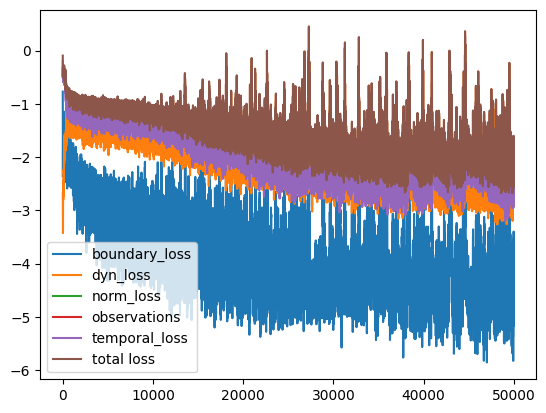

In [20]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

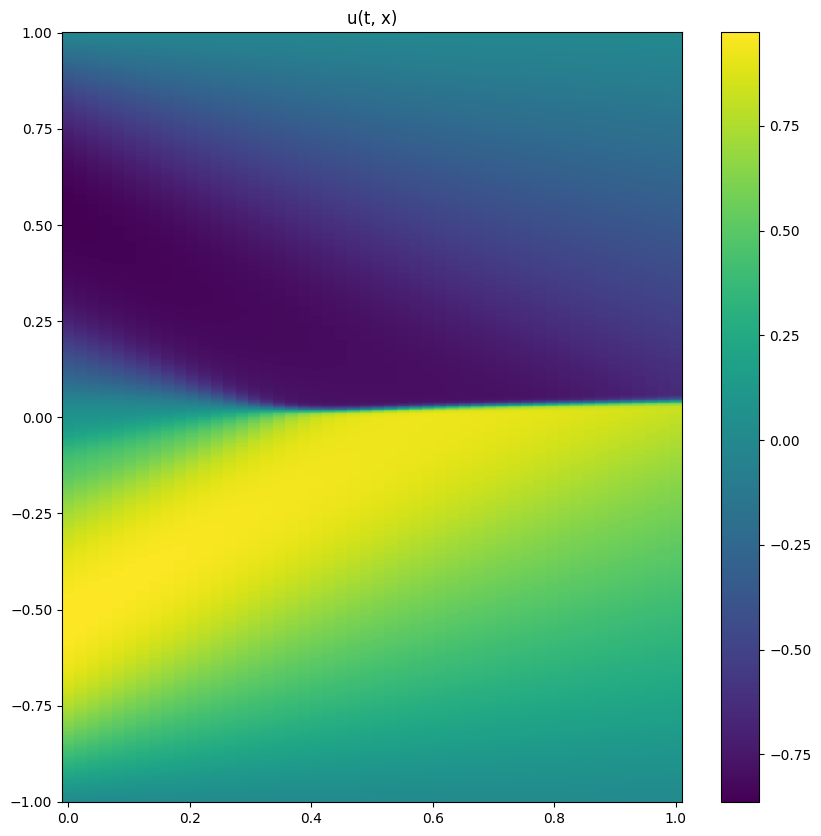

In [21]:
Tmax = 1
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

u_est = partial(u, u_params=params["nn_params"])

jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="u(t, x)")

## The stationary case

In case of a stationnary PDE, you may replace 
 * The PINN creation by the following call: `jinns.utils.create_PINN(key, eqx_list, eq_type="statio_PDE", dim_x=1)` which returns a function `u(x, nn_params, eq_params)` without the `t` input. The dimension of the first layer of the network bu me equal to $d$ in this case.
 * The `DataGenerator` in order to return only batch on $\Omega \times \partial \Omega$. See `CubicMeshPDEStatio` class.
 * The `LossPDENonStatio` class by the `LossPDEStatio` class (see the documentation and examples)

## Solving inverse PDE problems with jinns

**Warning:** this part of the package is still experimental.

